# 📷 Cifar-10 Image Classification

El conjunto de datos `CIFAR-10` consta de `60000` imágenes en color `32x32` en `10` clases, con `6000` imágenes por clase. Hay "50000" imágenes de entrenamiento y "10000" imágenes de prueba.

# 🔬 Definición del problema:

Dada una imagen, ¿podemos predecir la clase correcta de esta imagen?

Las imágenes son muy pequeñas (`32x32`) y al visualizarlas notarás lo difícil que es distinguirlas incluso para un humano.

En este cuaderno vamos a construir un modelo CNN que puede clasificar imágenes de varios objetos. Tenemos clase `10` de imágenes:
1. Avión
2. automóvil
3. pájaro
4. gato
5. ciervo
6. perro
7. rana
8. caballo
9. barco
10. camión

In [15]:
import pandas as pd
import numpy as np
import pickle, os, sys
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

# 📥 Load the data

In [16]:
# Función para desempaquetar los archivos
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Función para convertir los datos planos en imágenes de 32x32x3
def unpack_image(data, index):
    image = data[index].reshape(3, 32, 32).transpose(1, 2, 0)
    return image

def imgTo1D(img):
    resultado = []
    for i in img:
        for j in i:
            resultado.append(np.mean(j))
    return np.asarray(resultado).reshape(1, 32, 32).transpose(1, 2, 0)

def add_speckle_noise(image, noise_level):
    # Generar ruido speckle
    noise = noise_level * np.random.randn(*image.shape)
    noisy_image = image + image * noise
    noisy_image = np.clip(noisy_image, 0, 255)  # Asegurar que los valores de píxel sigan siendo válidos
    return noisy_image.astype(np.uint8)

In [17]:
# Lista para almacenar los datos
batches = []

# Update the data_dir path to the correct directory path
data_dir = os.path.join('../../01_data', 'cifar-10-batches-py')

# Cargar cada archivo en la carpeta
for filename in os.listdir(data_dir):
    if filename.startswith('data_batch'):
        file_path = os.path.join(data_dir, filename)
        print(filename)
        data_dict = unpickle(file_path)
        batches.append(data_dict)

# Ahora 'data' es una lista con todas las imágenes del conjunto de datos
print(f'Número total de batches procesados: {len(batches)}')

# Extraer la data y las etiquetas
data_train = np.vstack([batch[b'data'] for batch in batches])
labels_train = np.hstack([batch[b'labels'] for batch in batches])

data_batch_1
data_batch_2
data_batch_5
data_batch_4
data_batch_3
Número total de batches procesados: 5


In [18]:
# Lista para almacenar los datos
batches = []

# Update the data_dir path to the correct directory path
data_dir = os.path.join('../../01_data', 'cifar-10-batches-py')

# Cargar cada archivo en la carpeta
for filename in os.listdir(data_dir):
    if filename.startswith('data_test'):
        file_path = os.path.join(data_dir, filename)
        print(filename)
        data_dict = unpickle(file_path)
        batches.append(data_dict)

# Ahora 'data' es una lista con todas las imágenes del conjunto de datos
print(f'Número total de batches procesados: {len(batches)}')

# Extraer la data y las etiquetas
data_test = np.vstack([batch[b'data'] for batch in batches])
labels_test = np.hstack([batch[b'labels'] for batch in batches])

data_test_batch
Número total de batches procesados: 1


In [19]:
images1D_train = []
for i, img in enumerate(data_train):
    resultadoImgTo1D = imgTo1D(unpack_image(data_train, i))
    images1D_train.append(resultadoImgTo1D)
images1D_train = np.array(images1D_train)    

images1D_test = []
for i, img in enumerate(data_test):
    resultadoImgTo1D = imgTo1D(unpack_image(data_test, i))
    images1D_test.append(resultadoImgTo1D)
images1D_test = np.array(images1D_test)    

In [20]:
data_medium_noisy_train = []
label_medium_noisy_train = []
data_medium_noisy_test = []
label_medium_noisy_test = []


# Generar ruido speckle para todas las imágenes
for i, image in enumerate(images1D_train):
    noisy_image_medium = add_speckle_noise(imgTo1D(images1D_train[i]), 0.5)
    label_medium_noisy_train = labels_train[i]

    data_medium_noisy_train.append(noisy_image_medium)
data_medium_noisy_train = np.array(data_medium_noisy_train)

for i, image in enumerate(images1D_test):
    noisy_image_medium = add_speckle_noise(imgTo1D(images1D_test[i]), 0.5)
    label_medium_noisy_test = labels_test[i]

    data_medium_noisy_test.append(noisy_image_medium)
data_medium_noisy_test = np.array(data_medium_noisy_test)

In [21]:
X_train = data_medium_noisy_train
X_test = data_medium_noisy_test
y_train = np.array(labels_train)
y_test = np.array(labels_test)

In [22]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 1)
y_train shape: (50000,)
X_test shape: (10000, 32, 32, 1)
y_test shape: (10000,)


# 🖼 Data Visualization

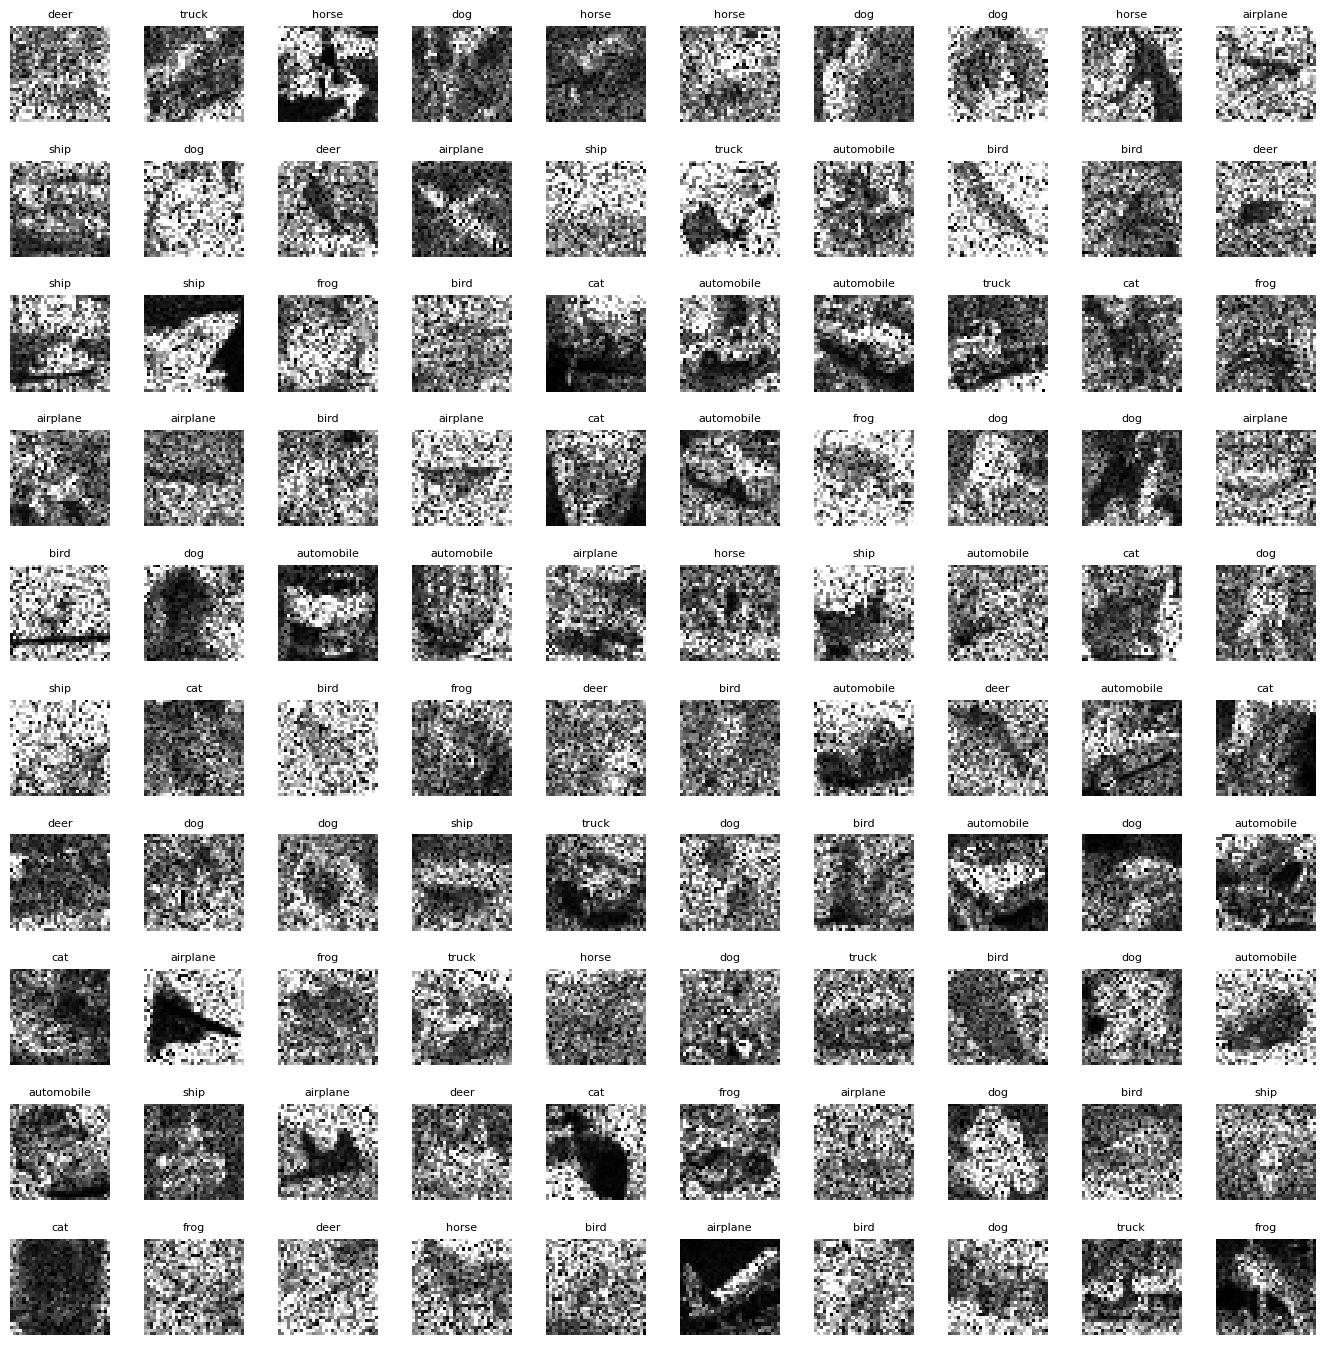

In [23]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(X_train[index,1:], cmap='gray')
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Text(0.5, 1.0, 'Class distribution in training set')

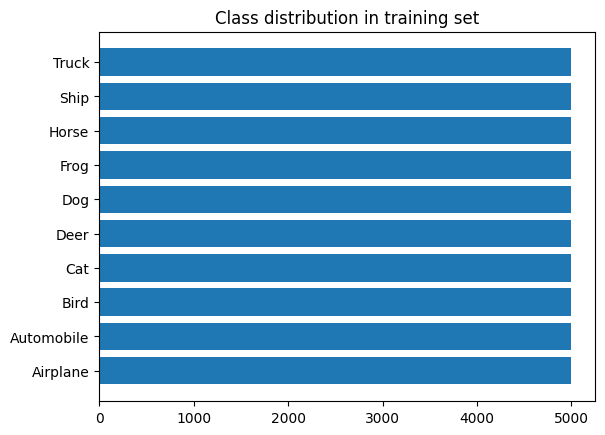

In [24]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

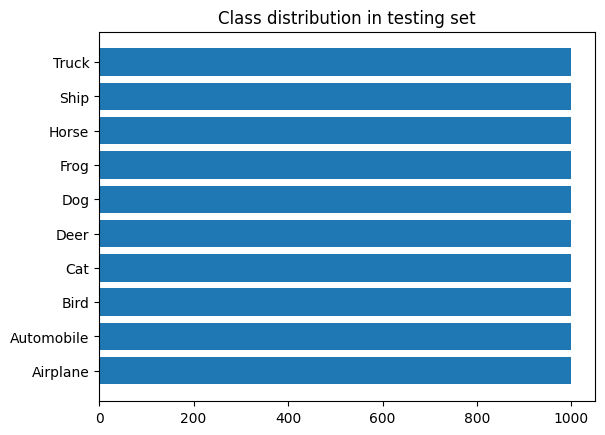

In [25]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

The class are equally distributed

# 🔄 Data Preprocessing

In [26]:
# Scale the data
#X_train = X_train / 255.0
#X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

In [27]:
y_cat_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

# 🤖 Model Building

In [28]:
INPUT_SHAPE = (32, 32, 1)
KERNEL_SIZE = (3, 3)
model = Sequential()

# Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
# Pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# Dropout layers
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

/Users/santiagomunera/miniconda3/envs/ml/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,29

 Total params: 551,786 (2.10 MB)

 Trainable params: 550,890 (2.10 MB)

 Non-trainable params: 896 (3.50 KB)

## Early Stopping

In [31]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

## Data Augmentations

In [32]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

r = model.fit(train_generator, 
              epochs=50,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test), 
#               callbacks=[early_stop],
#               batch_size=batch_size,
             )

Epoch 1/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:01:00 2s/step - accuracy: 0.2188 - loss: 4.8539 - precision: 0.2069 - recall: 0.1875

/Users/santiagomunera/miniconda3/envs/ml/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 133s 84ms/step - accuracy: 0.2187 - loss: 2.1842 - precision: 0.3664 - recall: 0.0245 - val_accuracy: 0.3602 - val_loss: 1.7344 - val_precision: 0.6190 - val_recall: 0.1118
Epoch 2/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:20 90ms/step - accuracy: 0.3125 - loss: 1.8099 - precision: 0.2857 - recall: 0.0625

2024-05-18 14:17:46.376664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/santiagomunera/miniconda3/envs/ml/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3125 - loss: 1.8099 - precision: 0.2857 - recall: 0.0625 - val_accuracy: 0.3543 - val_loss: 1.7495 - val_precision: 0.6151 - val_recall: 0.1090
Epoch 3/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 127s 81ms/step - accuracy: 0.3452 - loss: 1.7978 - precision: 0.5823 - recall: 0.1039 - val_accuracy: 0.4136 - val_loss: 1.5743 - val_precision: 0.6468 - val_recall: 0.1681
Epoch 4/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:21 90ms/step - accuracy: 0.3750 - loss: 1.9724 - precision: 1.0000 - recall: 0.1562

2024-05-18 14:19:59.622789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3750 - loss: 1.9724 - precision: 1.0000 - recall: 0.1562 - val_accuracy: 0.4176 - val_loss: 1.5649 - val_precision: 0.6542 - val_recall: 0.1695
Epoch 5/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 128s 82ms/step - accuracy: 0.3887 - loss: 1.7028 - precision: 0.6216 - recall: 0.1518 - val_accuracy: 0.4264 - val_loss: 1.5630 - val_precision: 0.6527 - val_recall: 0.2101
Epoch 6/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:15 87ms/step - accuracy: 0.4062 - loss: 1.9406 - precision: 0.3333 - recall: 0.0625

2024-05-18 14:22:13.658838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4062 - loss: 1.9406 - precision: 0.3333 - recall: 0.0625 - val_accuracy: 0.4243 - val_loss: 1.5676 - val_precision: 0.6532 - val_recall: 0.2100
Epoch 7/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 129s 83ms/step - accuracy: 0.4150 - loss: 1.6202 - precision: 0.6382 - recall: 0.1909 - val_accuracy: 0.4670 - val_loss: 1.4888 - val_precision: 0.6546 - val_recall: 0.2642
Epoch 8/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:16 87ms/step - accuracy: 0.5625 - loss: 1.1693 - precision: 0.8462 - recall: 0.3438

2024-05-18 14:24:29.430384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5625 - loss: 1.1693 - precision: 0.8462 - recall: 0.3438 - val_accuracy: 0.4725 - val_loss: 1.4757 - val_precision: 0.6615 - val_recall: 0.2622
Epoch 9/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 129s 83ms/step - accuracy: 0.4427 - loss: 1.5663 - precision: 0.6640 - recall: 0.2192 - val_accuracy: 0.5040 - val_loss: 1.4147 - val_precision: 0.7065 - val_recall: 0.2882
Epoch 10/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:02 78ms/step - accuracy: 0.4375 - loss: 1.5550 - precision: 0.8333 - recall: 0.3125

2024-05-18 14:26:45.439027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4375 - loss: 1.5550 - precision: 0.8333 - recall: 0.3125 - val_accuracy: 0.5022 - val_loss: 1.4212 - val_precision: 0.7061 - val_recall: 0.2866
Epoch 11/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 131s 84ms/step - accuracy: 0.4571 - loss: 1.5231 - precision: 0.6800 - recall: 0.2455 - val_accuracy: 0.5032 - val_loss: 1.4447 - val_precision: 0.6837 - val_recall: 0.3292
Epoch 12/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:16 87ms/step - accuracy: 0.4688 - loss: 1.4446 - precision: 0.8462 - recall: 0.3438

2024-05-18 14:29:03.364443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4688 - loss: 1.4446 - precision: 0.8462 - recall: 0.3438 - val_accuracy: 0.5051 - val_loss: 1.4352 - val_precision: 0.6854 - val_recall: 0.3324
Epoch 13/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 128s 82ms/step - accuracy: 0.4729 - loss: 1.4861 - precision: 0.6929 - recall: 0.2668 - val_accuracy: 0.5222 - val_loss: 1.3673 - val_precision: 0.7389 - val_recall: 0.3212
Epoch 14/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:22 91ms/step - accuracy: 0.5000 - loss: 1.2884 - precision: 0.7500 - recall: 0.3750

2024-05-18 14:31:17.696724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5000 - loss: 1.2884 - precision: 0.7500 - recall: 0.3750 - val_accuracy: 0.5232 - val_loss: 1.3654 - val_precision: 0.7393 - val_recall: 0.3255
Epoch 15/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 129s 82ms/step - accuracy: 0.4864 - loss: 1.4575 - precision: 0.6978 - recall: 0.2849 - val_accuracy: 0.5158 - val_loss: 1.3759 - val_precision: 0.7287 - val_recall: 0.3268
Epoch 16/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:07 82ms/step - accuracy: 0.5000 - loss: 1.2768 - precision: 0.7273 - recall: 0.2500

2024-05-18 14:33:32.621302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5000 - loss: 1.2768 - precision: 0.7273 - recall: 0.2500 - val_accuracy: 0.5146 - val_loss: 1.3821 - val_precision: 0.7236 - val_recall: 0.3210
Epoch 17/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 132s 84ms/step - accuracy: 0.4961 - loss: 1.4345 - precision: 0.7044 - recall: 0.2968 - val_accuracy: 0.5455 - val_loss: 1.2952 - val_precision: 0.7397 - val_recall: 0.3572
Epoch 18/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:42 104ms/step - accuracy: 0.5625 - loss: 1.4283 - precision: 0.7333 - recall: 0.3438

2024-05-18 14:35:51.044581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5625 - loss: 1.4283 - precision: 0.7333 - recall: 0.3438 - val_accuracy: 0.5470 - val_loss: 1.2903 - val_precision: 0.7419 - val_recall: 0.3579
Epoch 19/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 132s 85ms/step - accuracy: 0.5064 - loss: 1.4127 - precision: 0.7128 - recall: 0.3088 - val_accuracy: 0.5281 - val_loss: 1.3580 - val_precision: 0.7102 - val_recall: 0.3656
Epoch 20/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:10 83ms/step - accuracy: 0.6562 - loss: 1.1852 - precision: 0.8750 - recall: 0.4375

2024-05-18 14:38:09.268332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6562 - loss: 1.1852 - precision: 0.8750 - recall: 0.4375 - val_accuracy: 0.5262 - val_loss: 1.3630 - val_precision: 0.7076 - val_recall: 0.3659
Epoch 21/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 130s 83ms/step - accuracy: 0.5154 - loss: 1.3831 - precision: 0.7154 - recall: 0.3249 - val_accuracy: 0.5463 - val_loss: 1.3247 - val_precision: 0.7094 - val_recall: 0.4006
Epoch 22/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:44 105ms/step - accuracy: 0.6875 - loss: 0.9399 - precision: 0.8500 - recall: 0.5312

2024-05-18 14:40:25.481059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6875 - loss: 0.9399 - precision: 0.8500 - recall: 0.5312 - val_accuracy: 0.5485 - val_loss: 1.3191 - val_precision: 0.7111 - val_recall: 0.4021
Epoch 23/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 130s 83ms/step - accuracy: 0.5235 - loss: 1.3568 - precision: 0.7204 - recall: 0.3363 - val_accuracy: 0.5398 - val_loss: 1.3164 - val_precision: 0.7038 - val_recall: 0.3805
Epoch 24/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:19 89ms/step - accuracy: 0.5625 - loss: 1.2730 - precision: 0.6667 - recall: 0.3750

2024-05-18 14:42:42.491156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5625 - loss: 1.2730 - precision: 0.6667 - recall: 0.3750 - val_accuracy: 0.5376 - val_loss: 1.3222 - val_precision: 0.6961 - val_recall: 0.3797
Epoch 25/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 127s 81ms/step - accuracy: 0.5358 - loss: 1.3326 - precision: 0.7325 - recall: 0.3488 - val_accuracy: 0.5715 - val_loss: 1.2352 - val_precision: 0.7687 - val_recall: 0.3831
Epoch 26/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:20 90ms/step - accuracy: 0.4062 - loss: 1.4423 - precision: 0.7000 - recall: 0.2188

2024-05-18 14:44:55.457939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4062 - loss: 1.4423 - precision: 0.7000 - recall: 0.2188 - val_accuracy: 0.5739 - val_loss: 1.2303 - val_precision: 0.7698 - val_recall: 0.3838
Epoch 27/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 127s 81ms/step - accuracy: 0.5386 - loss: 1.3108 - precision: 0.7277 - recall: 0.3592 - val_accuracy: 0.5663 - val_loss: 1.2406 - val_precision: 0.7757 - val_recall: 0.3728
Epoch 28/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:34 99ms/step - accuracy: 0.7188 - loss: 1.0649 - precision: 0.9333 - recall: 0.4375

2024-05-18 14:47:08.768579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7188 - loss: 1.0649 - precision: 0.9333 - recall: 0.4375 - val_accuracy: 0.5660 - val_loss: 1.2411 - val_precision: 0.7757 - val_recall: 0.3724
Epoch 29/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 127s 81ms/step - accuracy: 0.5392 - loss: 1.3120 - precision: 0.7377 - recall: 0.3602 - val_accuracy: 0.5348 - val_loss: 1.3333 - val_precision: 0.6919 - val_recall: 0.3923
Epoch 30/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:24 93ms/step - accuracy: 0.5625 - loss: 1.0518 - precision: 0.8889 - recall: 0.5000

2024-05-18 14:49:21.988549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5625 - loss: 1.0518 - precision: 0.8889 - recall: 0.5000 - val_accuracy: 0.5353 - val_loss: 1.3334 - val_precision: 0.6933 - val_recall: 0.3936
Epoch 31/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 128s 82ms/step - accuracy: 0.5526 - loss: 1.2835 - precision: 0.7316 - recall: 0.3707 - val_accuracy: 0.5799 - val_loss: 1.1981 - val_precision: 0.7519 - val_recall: 0.4189
Epoch 32/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:09 83ms/step - accuracy: 0.4688 - loss: 1.3662 - precision: 0.6667 - recall: 0.3125

2024-05-18 14:51:36.824632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4688 - loss: 1.3662 - precision: 0.6667 - recall: 0.3125 - val_accuracy: 0.5767 - val_loss: 1.2041 - val_precision: 0.7479 - val_recall: 0.4200
Epoch 33/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 126s 80ms/step - accuracy: 0.5533 - loss: 1.2767 - precision: 0.7418 - recall: 0.3776 - val_accuracy: 0.5810 - val_loss: 1.1955 - val_precision: 0.7478 - val_recall: 0.4377
Epoch 34/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:07 82ms/step - accuracy: 0.5000 - loss: 1.2450 - precision: 0.6111 - recall: 0.3438

2024-05-18 14:53:48.639991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5000 - loss: 1.2450 - precision: 0.6111 - recall: 0.3438 - val_accuracy: 0.5791 - val_loss: 1.2006 - val_precision: 0.7445 - val_recall: 0.4380
Epoch 35/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 126s 80ms/step - accuracy: 0.5584 - loss: 1.2514 - precision: 0.7444 - recall: 0.3886 - val_accuracy: 0.5559 - val_loss: 1.2602 - val_precision: 0.7262 - val_recall: 0.3982
Epoch 36/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:08 83ms/step - accuracy: 0.4375 - loss: 1.5411 - precision: 0.7000 - recall: 0.2188

2024-05-18 14:56:01.053004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4375 - loss: 1.5411 - precision: 0.7000 - recall: 0.2188 - val_accuracy: 0.5544 - val_loss: 1.2631 - val_precision: 0.7260 - val_recall: 0.3966
Epoch 37/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 126s 81ms/step - accuracy: 0.5658 - loss: 1.2389 - precision: 0.7481 - recall: 0.3934 - val_accuracy: 0.5692 - val_loss: 1.2176 - val_precision: 0.7480 - val_recall: 0.4216
Epoch 38/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:24 93ms/step - accuracy: 0.5000 - loss: 1.4344 - precision: 0.6429 - recall: 0.2812

2024-05-18 14:58:12.877830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5000 - loss: 1.4344 - precision: 0.6429 - recall: 0.2812 - val_accuracy: 0.5667 - val_loss: 1.2186 - val_precision: 0.7450 - val_recall: 0.4210
Epoch 39/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 127s 81ms/step - accuracy: 0.5645 - loss: 1.2381 - precision: 0.7472 - recall: 0.3946 - val_accuracy: 0.6031 - val_loss: 1.1463 - val_precision: 0.7774 - val_recall: 0.4352
Epoch 40/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:57 76ms/step - accuracy: 0.5625 - loss: 1.2109 - precision: 0.7778 - recall: 0.4375

2024-05-18 15:00:25.533253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5625 - loss: 1.2109 - precision: 0.7778 - recall: 0.4375 - val_accuracy: 0.6015 - val_loss: 1.1464 - val_precision: 0.7774 - val_recall: 0.4356
Epoch 41/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 125s 80ms/step - accuracy: 0.5681 - loss: 1.2280 - precision: 0.7488 - recall: 0.4011 - val_accuracy: 0.5673 - val_loss: 1.2327 - val_precision: 0.7277 - val_recall: 0.4300
Epoch 42/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 3:06 119ms/step - accuracy: 0.5312 - loss: 1.4005 - precision: 1.0000 - recall: 0.3750

2024-05-18 15:02:36.243301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5312 - loss: 1.4005 - precision: 1.0000 - recall: 0.3750 - val_accuracy: 0.5704 - val_loss: 1.2227 - val_precision: 0.7314 - val_recall: 0.4307
Epoch 43/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 123s 79ms/step - accuracy: 0.5767 - loss: 1.2078 - precision: 0.7505 - recall: 0.4135 - val_accuracy: 0.5782 - val_loss: 1.2023 - val_precision: 0.7234 - val_recall: 0.4483
Epoch 44/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:23 92ms/step - accuracy: 0.6562 - loss: 1.0157 - precision: 0.8824 - recall: 0.4688

2024-05-18 15:04:45.301618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6562 - loss: 1.0157 - precision: 0.8824 - recall: 0.4688 - val_accuracy: 0.5771 - val_loss: 1.2087 - val_precision: 0.7212 - val_recall: 0.4487
Epoch 45/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 125s 80ms/step - accuracy: 0.5774 - loss: 1.2114 - precision: 0.7541 - recall: 0.4140 - val_accuracy: 0.5762 - val_loss: 1.2244 - val_precision: 0.7419 - val_recall: 0.4327
Epoch 46/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:01 78ms/step - accuracy: 0.4688 - loss: 1.5998 - precision: 0.6923 - recall: 0.2812

2024-05-18 15:06:56.369615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4688 - loss: 1.5998 - precision: 0.6923 - recall: 0.2812 - val_accuracy: 0.5769 - val_loss: 1.2235 - val_precision: 0.7398 - val_recall: 0.4314
Epoch 47/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 134s 86ms/step - accuracy: 0.5841 - loss: 1.1860 - precision: 0.7564 - recall: 0.4264 - val_accuracy: 0.6010 - val_loss: 1.1367 - val_precision: 0.7656 - val_recall: 0.4453
Epoch 48/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:21 91ms/step - accuracy: 0.5312 - loss: 1.1933 - precision: 0.6667 - recall: 0.4375

2024-05-18 15:09:16.070674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5312 - loss: 1.1933 - precision: 0.6667 - recall: 0.4375 - val_accuracy: 0.6010 - val_loss: 1.1353 - val_precision: 0.7663 - val_recall: 0.4456
Epoch 49/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - accuracy: 0.5857 - loss: 1.1759 - precision: 0.7566 - recall: 0.4232 - val_accuracy: 0.5988 - val_loss: 1.1356 - val_precision: 0.7589 - val_recall: 0.4590
Epoch 50/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:13 86ms/step - accuracy: 0.5625 - loss: 1.3334 - precision: 0.7500 - recall: 0.2812

2024-05-18 15:11:41.439829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5625 - loss: 1.3334 - precision: 0.7500 - recall: 0.2812 - val_accuracy: 0.5987 - val_loss: 1.1351 - val_precision: 0.7591 - val_recall: 0.4578


# 📊 Model Evaluation

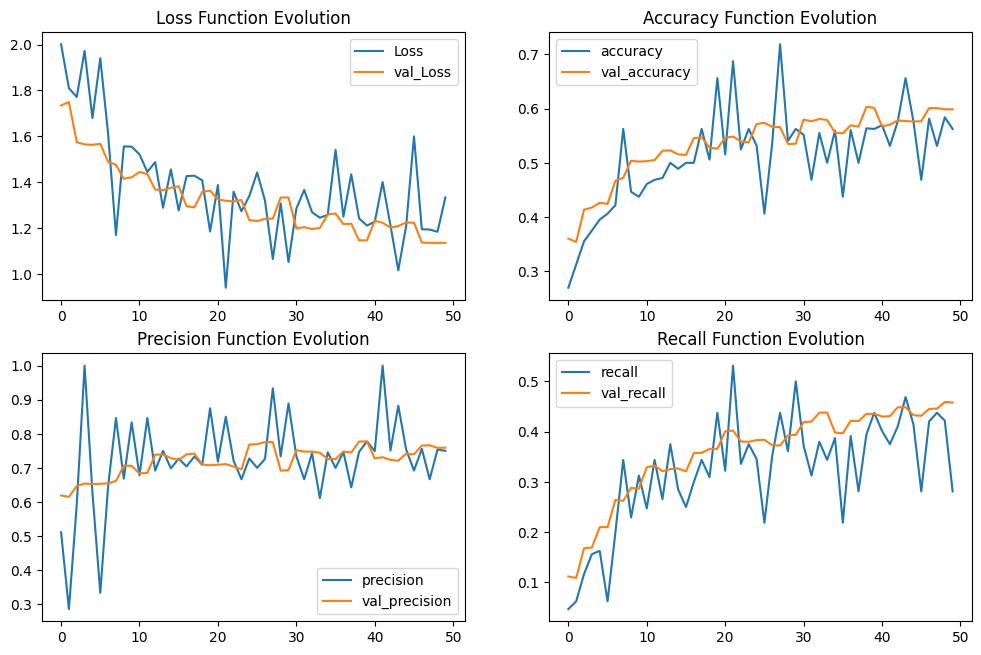

In [33]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6030 - loss: 1.1256 - precision: 0.7646 - recall: 0.4632
Test Accuracy : 59.87%
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


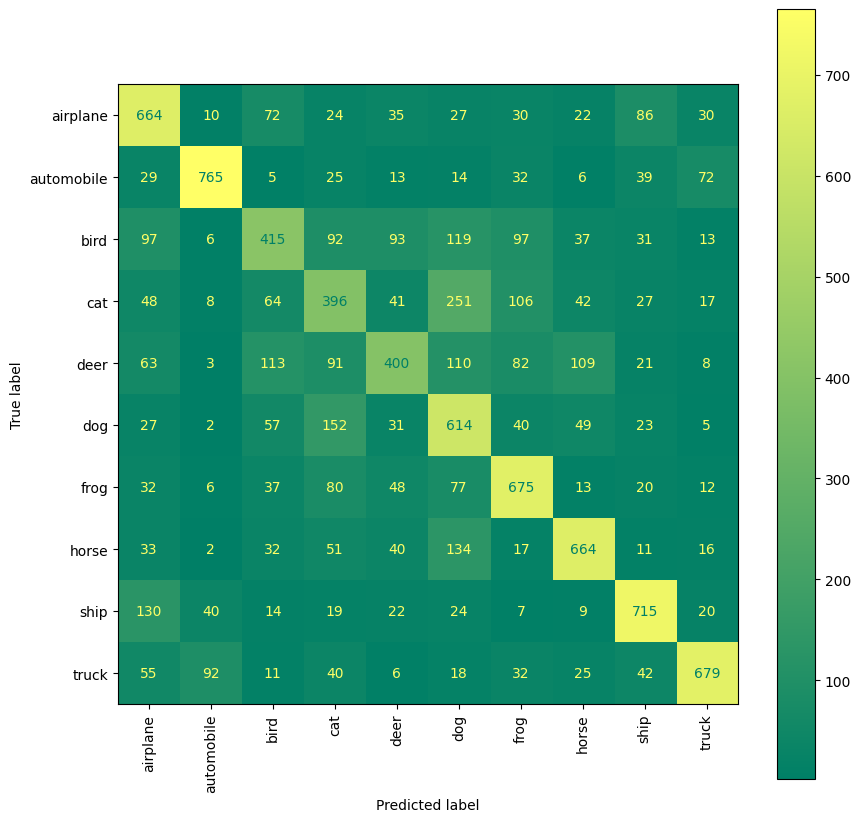

In [34]:
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.66      0.61      1000
           1       0.82      0.77      0.79      1000
           2       0.51      0.41      0.46      1000
           3       0.41      0.40      0.40      1000
           4       0.55      0.40      0.46      1000
           5       0.44      0.61      0.51      1000
           6       0.60      0.68      0.64      1000
           7       0.68      0.66      0.67      1000
           8       0.70      0.71      0.71      1000
           9       0.78      0.68      0.73      1000

    accuracy                           0.60     10000
   macro avg       0.61      0.60      0.60     10000
weighted avg       0.61      0.60      0.60     10000



## Test on one image

 Image 100 is 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
The model predict that image 100 is 7


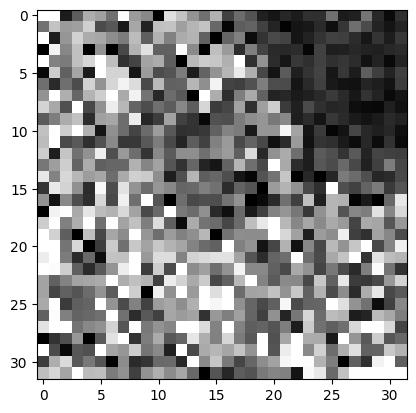

In [36]:
my_image = X_test[100]
plt.imshow(my_image, cmap='gray')

# that's a Deer
print(f" Image 100 is {y_test[100]}")

# correctly predicted as a Deer
pred_100 = np.argmax(model.predict(my_image.reshape(1, 32, 32, 1)))
print(f"The model predict that image 100 is {pred_100}")

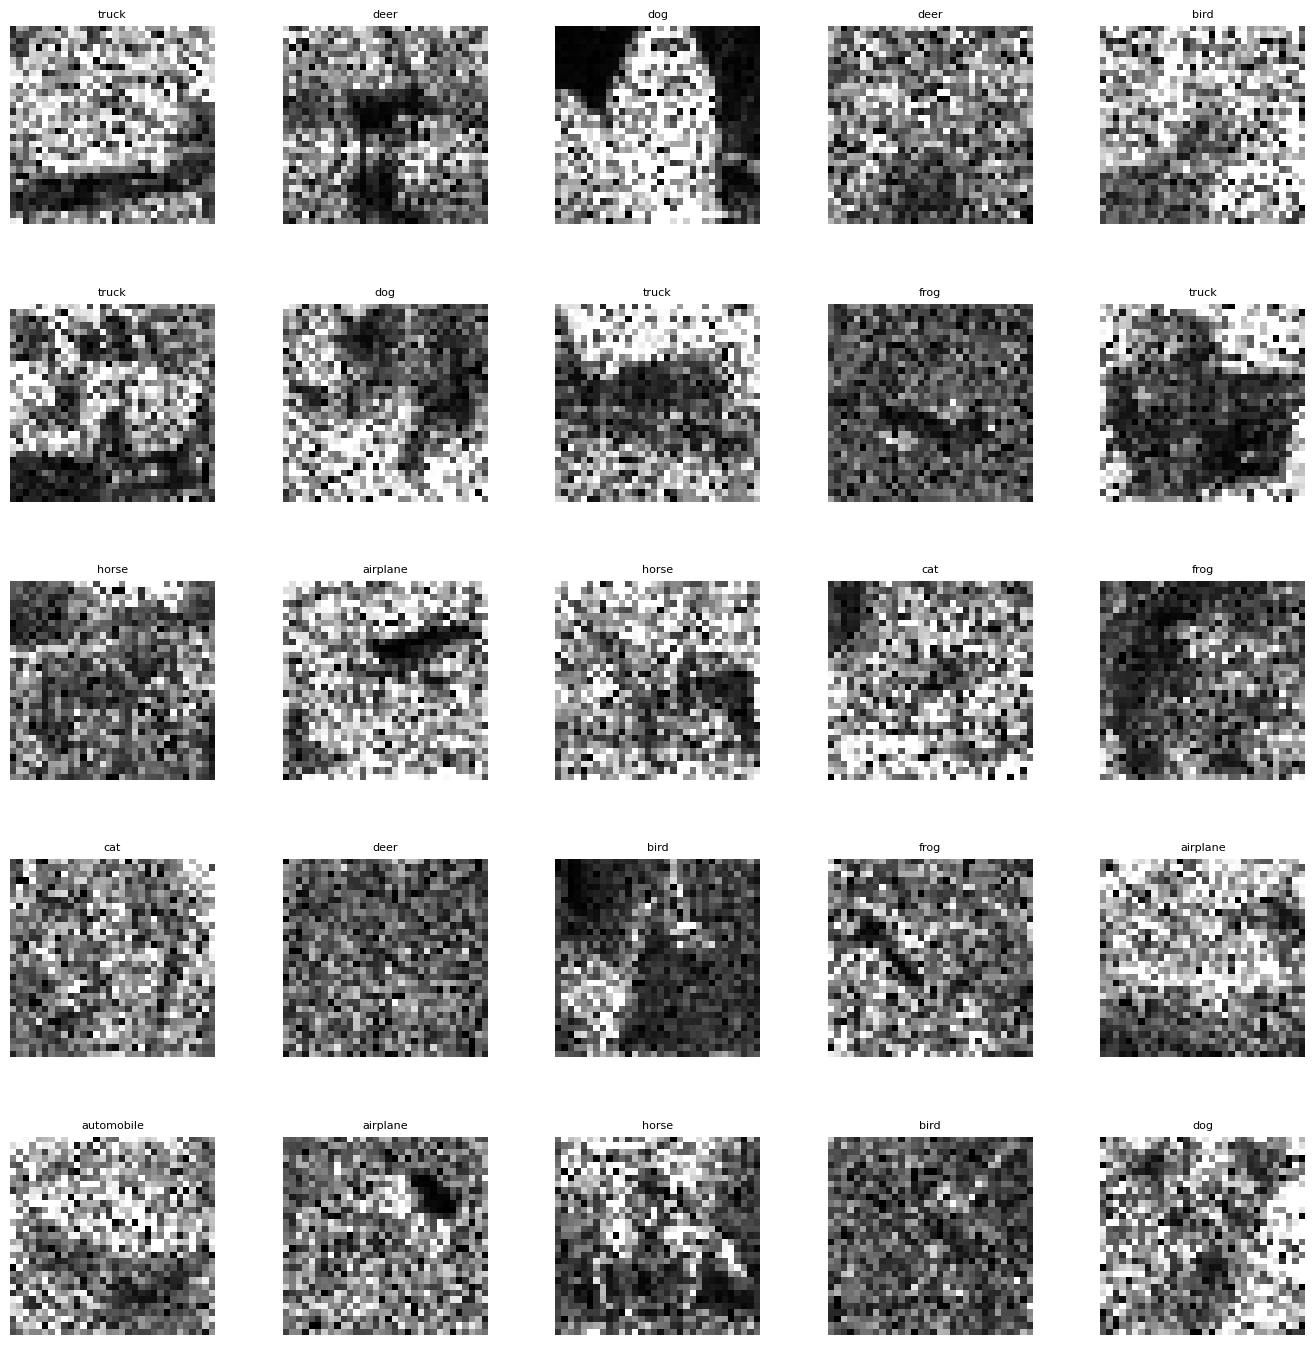

In [37]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_test = len(X_test) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_test)
    # read and display an image with the selected index    
    axes[i].imshow(X_test[index,1:], cmap='gray')
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [38]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step


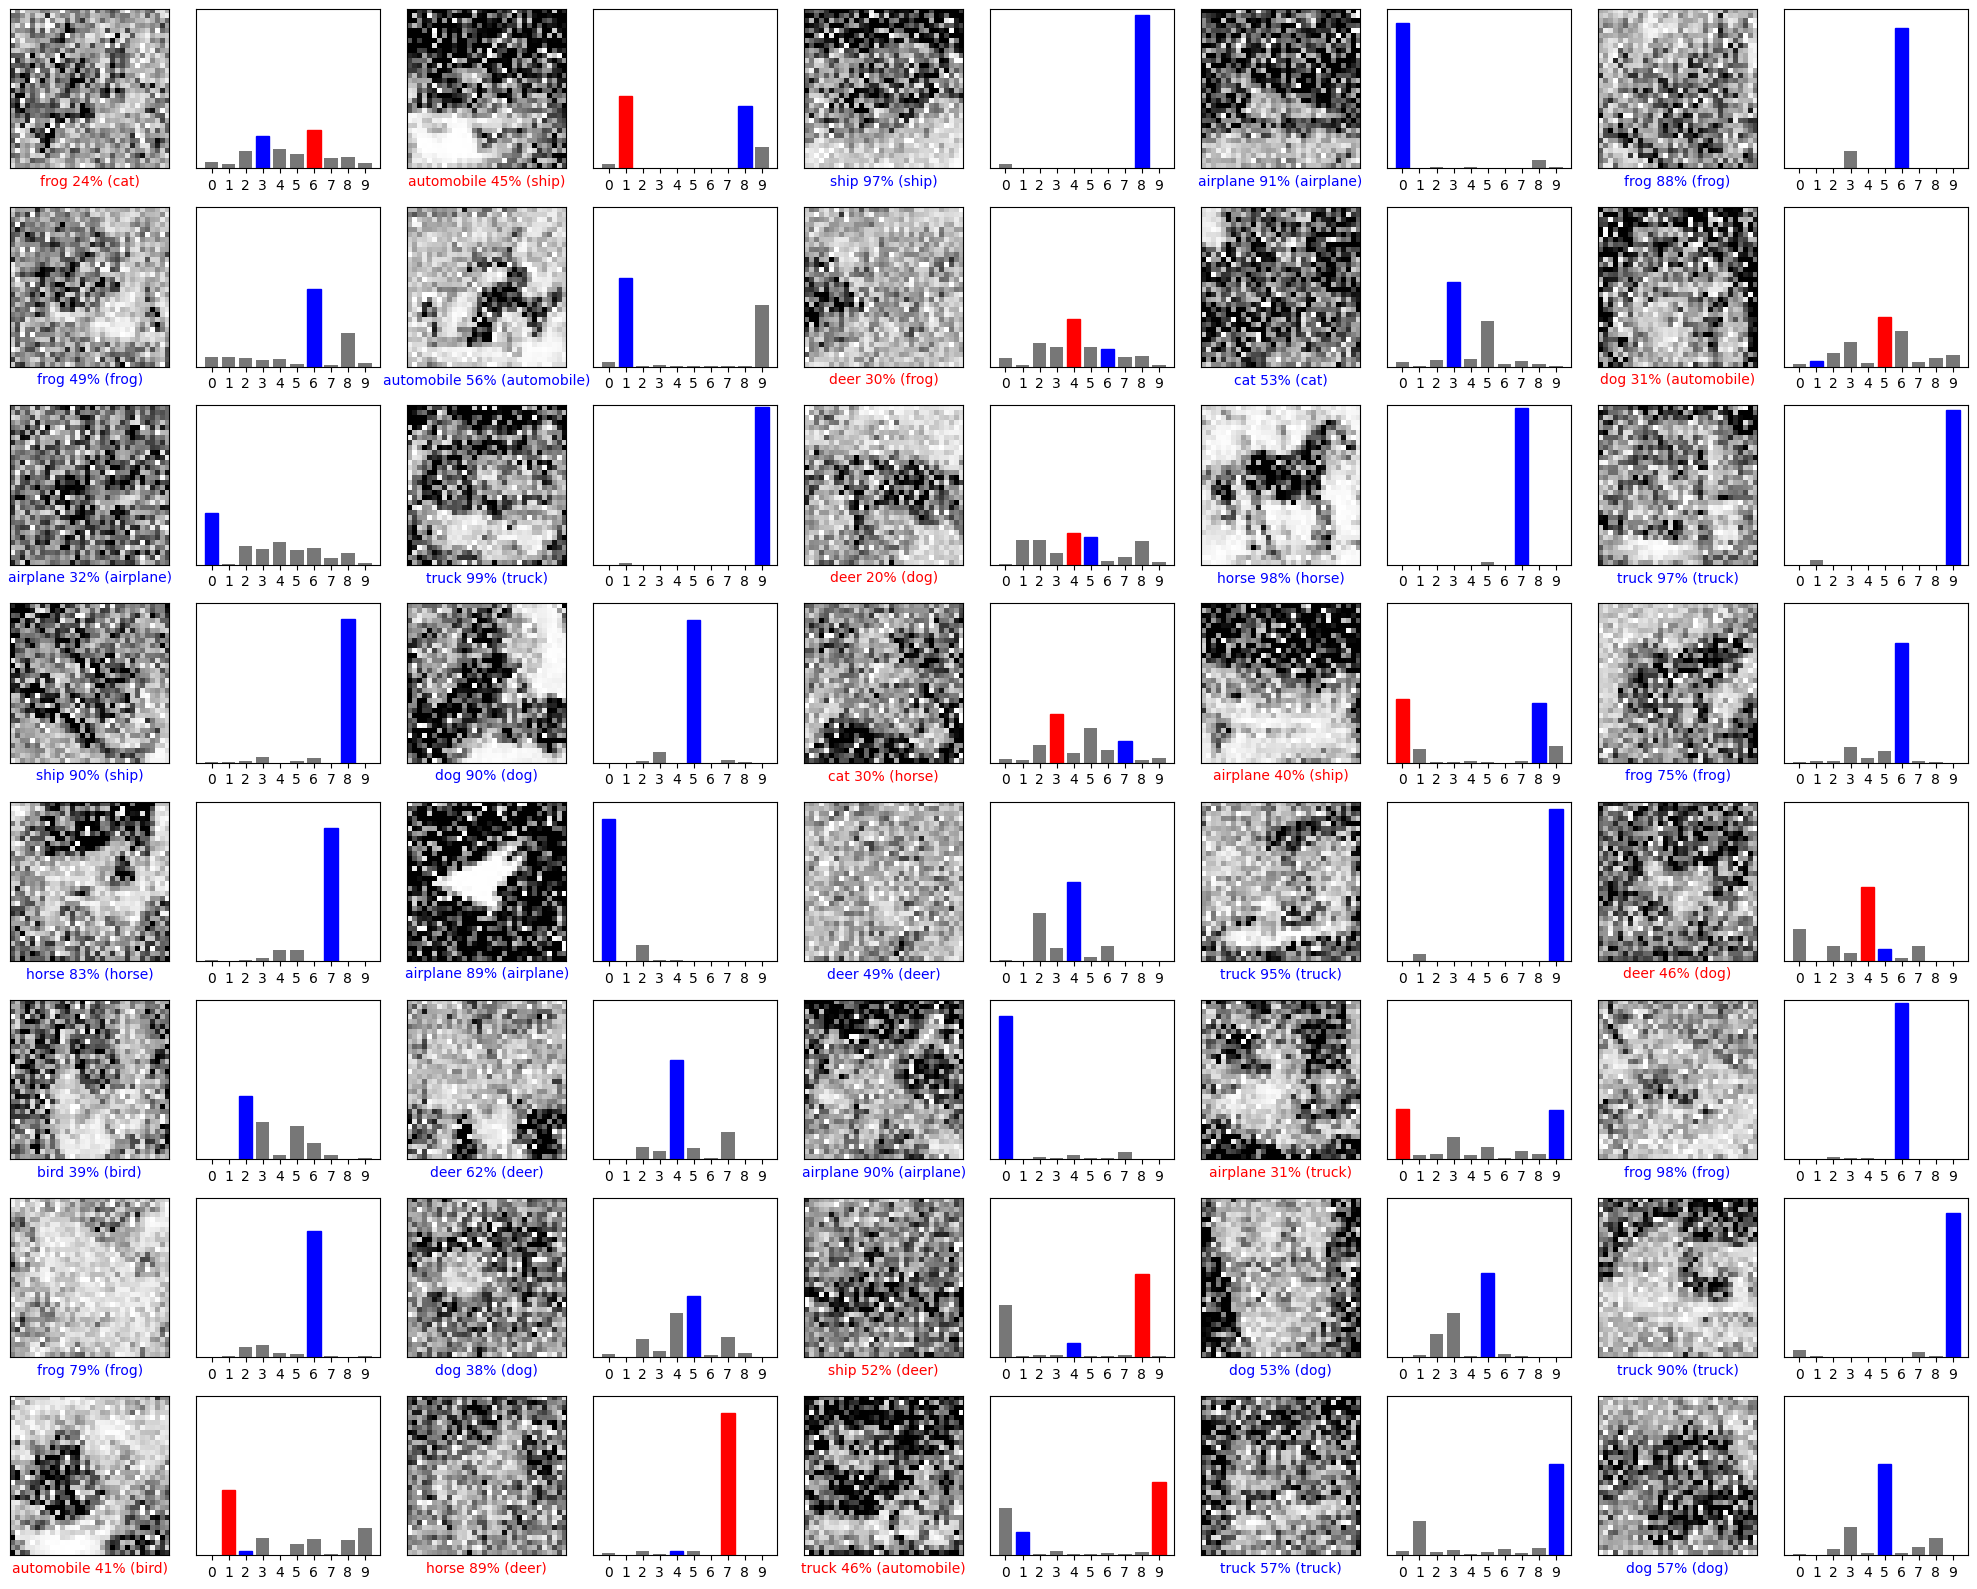

In [39]:
predictions = model.predict(X_test)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()